In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from hlxon_hdf5io import *
import random
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt

In [2]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [3]:
def angular_distance(b, a):
    return np.where(np.abs(b-a)%360 < 180, b-a, np.where((b-a) > 0, 360 - ((b-a)%360), 360 - ((a-b)%360)))

In [4]:
X, Y, Z = 0, 1, 2 # convenience

In [5]:
# load dataset
dataset = readAll()

dataset_resampled = []
for seq in dataset:
    raw_timestamp, raw_9dof, raw_rpy, raw_bno, raw_bmp, raw_pressure, wifidata, gt_timestamp, gt_position, gt_orientation = seq

    # get sensor data
    araw = np.array(raw_9dof[:, :3])
    gyro = np.array(raw_9dof[:, 3:6])
    magn = np.array(raw_9dof[:, 6:])
    pres = np.array(raw_pressure).reshape((-1, 1))
    alpha = 1.16e-4
    ts = np.array(raw_timestamp)*1e-6
    gt_timestamp = np.array(gt_timestamp)*1e-6


    # interpolate gt orientations
    rots = np.array([Rotation.from_quat(q).as_euler('xyz', degrees=True) for q in gt_orientation]) # change quat gt rots to euler
    rots -= rots[0] # normalize to initial rot
    rots = rots[:, ::-1] # reverse order of xyz to match ndof
    rots[:, X] *= -1 # invert X rotations to match ndof
    rots = np.array([Rotation.from_euler('xyz', r, degrees=True).as_euler('xyz', degrees=True) for r in rots])

    # lerp rots
    N = len(rots)

    # interpolate ground truth over timestamps
    lerped_rotations = np.zeros((N, 3))
    for i in range(N):
        if gt_timestamp[i] in ts:
            lerped_rotations[i] = raw_rpy[np.argmax(ts == gt_timestamp[i])]
        else:
            # lerp
            ix_2 = np.argmax(ts > gt_timestamp[i])
            ix_1 = ts.shape[0] - np.argmax(np.flip(ts, axis=0) < gt_timestamp[i]) - 1

            lerped_rotations[i] = raw_rpy[ix_1] + (gt_timestamp[i]-ts[ix_1])*angular_distance(raw_rpy[ix_2], raw_rpy[ix_1])/(ts[ix_2] - ts[ix_1] + 1e-10)

    rpy = lerped_rotations

    # interpolate over time to create single sampling rate
    fs = len(gt_timestamp) / gt_timestamp[-1]
    CNT = int(fs*gt_timestamp[-1])
    unified_ts = np.linspace(0, gt_timestamp[-1], CNT)

    lerpedrpy = np.zeros((CNT, 3))
    lerpedrots = np.zeros((CNT, 3))
    lerpedaccel = np.zeros((CNT, 3))
    lerpedpres = np.zeros((CNT, 1))
    lerpedmagn = np.zeros((CNT, 3))


    for i in range(CNT):
        if unified_ts[i] in gt_timestamp:
            lerpedrpy[i] = rpy[np.argmax(gt_timestamp == unified_ts[i])]
            lerpedrots[i] = rots[np.argmax(gt_timestamp == unified_ts[i])]

        else:
            # lerp
            ix_2 = np.argmax(gt_timestamp > unified_ts[i])
            ix_1 = gt_timestamp.shape[0] - np.argmax(np.flip(gt_timestamp, axis=0) < unified_ts[i]) - 1

            lerpedrpy[i] = rpy[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(rpy[ix_2], rpy[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)
            lerpedrots[i] = rots[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(rots[ix_2], rots[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)
            lerpedaccel[i] = araw[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(araw[ix_2], araw[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)
            lerpedpres[i] = pres[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(pres[ix_2], pres[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)
            lerpedmagn[i] = magn[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(magn[ix_2], magn[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)


    rots = lerpedrots
    rpy = lerpedrpy
    accel = lerpedaccel
    pres = lerpedpres
    magn = lerpedmagn

    dataset_resampled += [(np.concatenate((rpy, accel, magn, pres), axis=1), rots)]

dataset = dataset_resampled

In [6]:
# utility function to get a sequence
def get_sequence(sequence_length, dataset_index):
    X_seq, y_seq = dataset[dataset_index]
    
    ix = random.randint(0, len(X_seq)-sequence_length-1)
    X_seq, y_seq = X_seq[ix:ix+sequence_length], y_seq[ix:ix+sequence_length]
    
    return X_seq, y_seq

N = 10

In [7]:
class OrientationNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.inputhead = nn.Sequential(
            nn.Linear(N, N),
            nn.Dropout(.2),
            nn.BatchNorm1d(N),
            nn.LeakyReLU(),
        )
        self.residual = nn.Sequential(
            nn.Linear(N, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 100),
        )
        self.rnn = nn.LSTM(N, 100)
        self.outputhead = nn.Sequential(
            nn.Linear(100, 1000),
            nn.BatchNorm1d(1000),
            nn.LeakyReLU(),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(),
            
            nn.Linear(1000, 100),
            nn.LeakyReLU(),
            nn.Dropout(.2),
            nn.Linear(100, 3)
        )
    
    def forward(self, x):
        x = self.inputhead(x)
        resid = self.residual(x)
        x, ht = self.rnn(x)
        x = self.outputhead(x+resid)
        
        return x

In [8]:
model = OrientationNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5)
batch_size = 300
report_every = 10

In [9]:
all_losses = []
model.train()

n_epoch = 200
for iter in range(1, n_epoch + 1):
    model.zero_grad()

    current_loss = 0
    nbatches = 50
    for ix in range(nbatches):
        dset_ix = random.randint(0, len(dataset_resampled)-2)
        X_seq, y_seq = get_sequence(batch_size, dset_ix)
        X_seq, y_seq = torch.tensor(X_seq, device=device, dtype=torch.float), torch.tensor(y_seq, device=device, dtype=torch.float)
        
        y_pred = model.forward(X_seq)
        loss = torch.mean((((y_seq-y_pred) + 180) % 360 - 180) ** 2 / batch_size)
        current_loss += loss 

    # optimize parameters
    current_loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 3)
    optimizer.step()
    optimizer.zero_grad()

    all_losses.append(current_loss / (nbatches) )
    if iter % report_every == 0:
        print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")

    

10 (5%): 	 average batch loss = 12.522676467895508
20 (10%): 	 average batch loss = 11.919540405273438
30 (15%): 	 average batch loss = 12.581918716430664
40 (20%): 	 average batch loss = 12.344592094421387
50 (25%): 	 average batch loss = 12.175642013549805
60 (30%): 	 average batch loss = 11.417244911193848
70 (35%): 	 average batch loss = 12.057361602783203
80 (40%): 	 average batch loss = 12.549333572387695
90 (45%): 	 average batch loss = 11.942532539367676
100 (50%): 	 average batch loss = 11.902776718139648
110 (55%): 	 average batch loss = 12.562566757202148
120 (60%): 	 average batch loss = 12.07332992553711
130 (65%): 	 average batch loss = 11.557194709777832
140 (70%): 	 average batch loss = 11.735882759094238
150 (75%): 	 average batch loss = 11.56013011932373
160 (80%): 	 average batch loss = 11.536884307861328
170 (85%): 	 average batch loss = 11.912358283996582
180 (90%): 	 average batch loss = 11.624411582946777
190 (95%): 	 average batch loss = 11.090927124023438
200 (

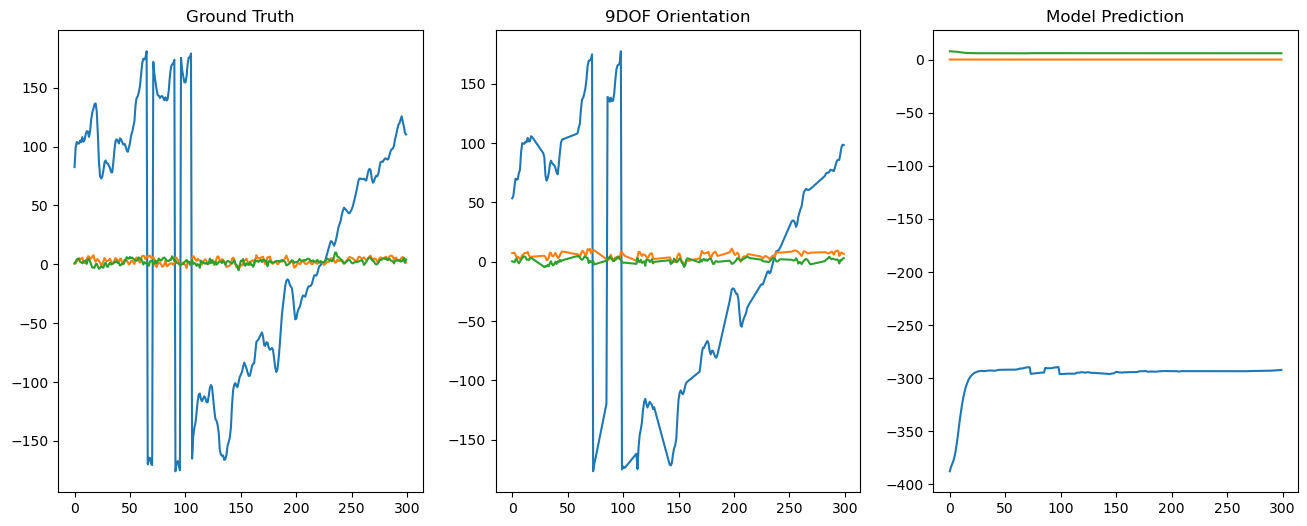

In [10]:
with torch.no_grad():

    model.eval()

    X_seq, y_seq = get_sequence(batch_size, dset_ix)
    X_seq = torch.tensor(X_seq, device=device, dtype=torch.float)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

    X_ori = torch.Tensor.cpu(X_seq[:, :3])

    y_pred = model.forward(X_seq)
    y_pred = torch.Tensor.cpu(y_pred)
    ax1.plot(y_seq)
    ax1.set_title('Ground Truth')
    ax2.plot(X_ori) 
    ax2.set_title('9DOF Orientation')
    ax3.plot(y_pred)
    ax3.set_title('Model Prediction')

    plt.show()
